# **Air Quality Data Analysis Project**
  > Nama: Made Pranajaya Dibyacita

  > Email: mdpranajaya@gmail.com
  
  > ID Dicoding: [mdprana](https://www.dicoding.com/users/mdprana/academies)

## **Defining Questions**

1.   Which pollutant has the highest average concentration across all monitoring sites?
2.   Which weather conditions (e.g., wind speed, humidity) have the strongest influence on air quality?
3.   Is there a long-term trend in air quality improvement or deterioration over the years?

## **Prepare required libraries**

Begin by importing the necessary Python libraries for data analysis and visualization

In [140]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

## **1. Data Wrangling**

### 1.1 Gathering Data

Load air quality data from multiple CSV files, each representing a different monitoring station in Beijing.

In [141]:
# Set the data directory
data_dir = "./data/" 

file_list = [
    'PRSA_Data_Aotizhongxin_20130301-20170228.csv',
    'PRSA_Data_Changping_20130301-20170228.csv',
    'PRSA_Data_Dingling_20130301-20170228.csv',
    'PRSA_Data_Dongsi_20130301-20170228.csv',
    'PRSA_Data_Guanyuan_20130301-20170228.csv',
    'PRSA_Data_Gucheng_20130301-20170228.csv',
    'PRSA_Data_Huairou_20130301-20170228.csv',
    'PRSA_Data_Nongzhanguan_20130301-20170228.csv',
    'PRSA_Data_Shunyi_20130301-20170228.csv',
    'PRSA_Data_Tiantan_20130301-20170228.csv',
    'PRSA_Data_Wanliu_20130301-20170228.csv',
    'PRSA_Data_Wanshouxigong_20130301-20170228.csv'
]

# Dictionary to store dataframes
air_quality_data = {}

In [142]:
# Load each file
for file in file_list:
    station_name = file.split('_')[2]  # Get station name from filename
    file_path = data_dir + file
    air_quality_data[station_name] = pd.read_csv(file_path)
    print(f"Loaded data for {station_name}")

Loaded data for Aotizhongxin
Loaded data for Changping
Loaded data for Dingling
Loaded data for Dongsi
Loaded data for Guanyuan
Loaded data for Gucheng
Loaded data for Huairou
Loaded data for Nongzhanguan
Loaded data for Shunyi
Loaded data for Tiantan
Loaded data for Wanliu
Loaded data for Wanshouxigong


### 1.2 Assessing Data

Create a function to assess each dataset, checking for data types, duplicates, missing values, and other key information

In [143]:
# Define assessment function
def assess_data(df):
    print("\n1. Data Types:")
    print(df.dtypes)
    
    print("\n2. Checking for Duplicates:")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    
    print("\n3. Checking for Missing Values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    print("\n4. Additional Information:")
    print(f"Total number of rows: {len(df)}")
    print(f"Total number of columns: {len(df.columns)}")
    
    print("\n5. Sample of the data (first 3 rows):")
    print(df.head(3))

In [144]:
# Assess each dataset
for station, df in air_quality_data.items():
    print(f"\n{'='*50}")
    print(f"Assessing data for {station}")
    print(f"{'='*50}")
    assess_data(df)


Assessing data for Aotizhongxin

1. Data Types:
No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object

2. Checking for Duplicates:
Number of duplicate rows: 0

3. Checking for Missing Values:
PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         81
WSPM       14
dtype: int64

4. Additional Information:
Total number of rows: 35064
Total number of columns: 18

5. Sample of the data (first 3 rows):
   No  year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0  4.0  

In [145]:
# Calculate summary statistics
total_rows = sum(len(df) for df in air_quality_data.values())
total_duplicates = sum(df.duplicated().sum() for df in air_quality_data.values())
total_missing = sum(df.isnull().sum().sum() for df in air_quality_data.values())

# Print summary
print("\n" + "="*50)
print("Summary of Assessment Across All Stations")
print("="*50)
print(f"\nTotal number of rows across all stations: {total_rows}")
print(f"Total number of duplicates across all stations: {total_duplicates}")
print(f"Total number of missing values across all stations: {total_missing}")

# List columns with missing values
print("\nColumns with missing values across all stations:")
for column in air_quality_data[list(air_quality_data.keys())[0]].columns:
    missing_count = sum(df[column].isnull().sum() for df in air_quality_data.values())
    if missing_count > 0:
        print(f"{column}: {missing_count} missing values")


Summary of Assessment Across All Stations

Total number of rows across all stations: 420768
Total number of duplicates across all stations: 0
Total number of missing values across all stations: 74027

Columns with missing values across all stations:
PM2.5: 8739 missing values
PM10: 6449 missing values
SO2: 9021 missing values
NO2: 12116 missing values
CO: 20701 missing values
O3: 13277 missing values
TEMP: 398 missing values
PRES: 393 missing values
DEWP: 403 missing values
RAIN: 390 missing values
wd: 1822 missing values
WSPM: 318 missing values


### **1.3 Data Cleaning**

**The data cleaning process involves several steps:**
1. Removing rows with missing values
2. Converting date and time columns to a single datetime column
3. Removing original date and time columns

In [146]:
# Function to clean a single dataframe
def clean_air_quality_data(df):
    # Remove rows with missing values
    df_clean = df.dropna().copy()
    
    # Convert date and time columns to a single datetime column
    df_clean['datetime'] = pd.to_datetime(df_clean[['year', 'month', 'day', 'hour']])
    
    # Remove the original date and time columns
    df_clean = df_clean.drop(['year', 'month', 'day', 'hour'], axis=1)
    
    return df_clean

In [147]:
# Clean all stations
cleaned_data = {}
for station, df in air_quality_data.items():
    print(f"\nCleaning data for {station}")
    print("Rows before cleaning:", len(df))
    
    cleaned_df = clean_air_quality_data(df)
    
    print("Rows after cleaning:", len(cleaned_df))
    print("First few rows of cleaned data:")
    print(cleaned_df.head())
    
    cleaned_data[station] = cleaned_df


Cleaning data for Aotizhongxin
Rows before cleaning: 35064
Rows after cleaning: 31815
First few rows of cleaned data:
   No  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN   wd  \
0   1    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  NNW   
1   2    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0    N   
2   3    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0  NNW   
3   4    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   NW   
4   5    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0    N   

   WSPM       station            datetime  
0   4.4  Aotizhongxin 2013-03-01 00:00:00  
1   4.7  Aotizhongxin 2013-03-01 01:00:00  
2   5.6  Aotizhongxin 2013-03-01 02:00:00  
3   3.1  Aotizhongxin 2013-03-01 03:00:00  
4   2.0  Aotizhongxin 2013-03-01 04:00:00  

Cleaning data for Changping
Rows before cleaning: 35064
Rows after cleaning: 32681
First few rows of cleaned data:
   No  PM2.5  PM10   SO2   NO2  

In [148]:
# Save all cleaned datasets in the 'data' folder
for station, df in cleaned_data.items():
    filename = f'./data/{station}_clean.csv'
    df.to_csv(filename, index=False)
    print(f"\nCleaned data for {station} saved to '{filename}'")


Cleaned data for Aotizhongxin saved to './data/Aotizhongxin_clean.csv'

Cleaned data for Changping saved to './data/Changping_clean.csv'

Cleaned data for Dingling saved to './data/Dingling_clean.csv'

Cleaned data for Dongsi saved to './data/Dongsi_clean.csv'

Cleaned data for Guanyuan saved to './data/Guanyuan_clean.csv'

Cleaned data for Gucheng saved to './data/Gucheng_clean.csv'

Cleaned data for Huairou saved to './data/Huairou_clean.csv'

Cleaned data for Nongzhanguan saved to './data/Nongzhanguan_clean.csv'

Cleaned data for Shunyi saved to './data/Shunyi_clean.csv'

Cleaned data for Tiantan saved to './data/Tiantan_clean.csv'

Cleaned data for Wanliu saved to './data/Wanliu_clean.csv'

Cleaned data for Wanshouxigong saved to './data/Wanshouxigong_clean.csv'


In [149]:
# Summary of cleaning
print("\nSummary of cleaning process:")
for station in cleaned_data:
    original_rows = len(air_quality_data[station])
    cleaned_rows = len(cleaned_data[station])
    removed_rows = original_rows - cleaned_rows
    print(f"{station}: Removed {removed_rows} rows ({removed_rows/original_rows*100:.2f}% of data)")


Summary of cleaning process:
Aotizhongxin: Removed 3249 rows (9.27% of data)
Changping: Removed 2383 rows (6.80% of data)
Dingling: Removed 3758 rows (10.72% of data)
Dongsi: Removed 4726 rows (13.48% of data)
Guanyuan: Removed 2801 rows (7.99% of data)
Gucheng: Removed 2560 rows (7.30% of data)
Huairou: Removed 3356 rows (9.57% of data)
Nongzhanguan: Removed 1950 rows (5.56% of data)
Shunyi: Removed 4870 rows (13.89% of data)
Tiantan: Removed 2221 rows (6.33% of data)
Wanliu: Removed 4430 rows (12.63% of data)
Wanshouxigong: Removed 2296 rows (6.55% of data)


In [150]:
# Check remaining missing values
print("\nRemaining missing values:")
for station, df in cleaned_data.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{station}:")
        print(missing[missing > 0])
    else:
        print(f"\n{station}: No missing values")


Remaining missing values:

Aotizhongxin: No missing values

Changping: No missing values

Dingling: No missing values

Dongsi: No missing values

Guanyuan: No missing values

Gucheng: No missing values

Huairou: No missing values

Nongzhanguan: No missing values

Shunyi: No missing values

Tiantan: No missing values

Wanliu: No missing values

Wanshouxigong: No missing values


In [151]:
# Basic statistics for one station (e.g., the first one)
first_station = list(cleaned_data.keys())[0]
print(f"\nBasic statistics for {first_station}:")
print(cleaned_data[first_station].describe())


Basic statistics for Aotizhongxin:
                 No        PM2.5          PM10           SO2           NO2  \
count  31815.000000  31815.00000  31815.000000  31815.000000  31815.000000   
mean   17899.423857     81.86363    109.120685     17.167205     58.976332   
min        1.000000      3.00000      2.000000      0.571200      2.000000   
25%     9415.500000     22.00000     37.000000      3.000000     30.000000   
50%    18093.000000     58.00000     86.000000      8.000000     53.000000   
75%    26590.500000    114.00000    154.000000     21.000000     82.000000   
max    35064.000000    713.00000    948.000000    229.000000    290.000000   
std    10058.429849     80.44949     93.718017     22.760801     37.061384   

                 CO            O3          TEMP          PRES          DEWP  \
count  31815.000000  31815.000000  31815.000000  31815.000000  31815.000000   
mean    1256.574729     56.240938     13.775611   1011.800385      3.241106   
min      100.000000     

## **2. Exploratory Data Analysis (EDA)**

### 3.1 Loading Cleaned Data

Load the cleaned data and perform initial explorations

In [152]:
# Load all cleaned CSV files from the data folder
data_folder = './data/'
cleaned_data = {}

for file in os.listdir(data_folder):
    if file.endswith('_clean.csv'):
        station_name = file.split('_clean.csv')[0]
        df = pd.read_csv(os.path.join(data_folder, file))
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        cleaned_data[station_name] = df
        print(f"Loaded cleaned data for {station_name}")

print(f"Total number of stations: {len(cleaned_data)}")

Loaded cleaned data for Aotizhongxin
Loaded cleaned data for Changping
Loaded cleaned data for Dingling
Loaded cleaned data for Dongsi
Loaded cleaned data for Guanyuan
Loaded cleaned data for Gucheng
Loaded cleaned data for Huairou
Loaded cleaned data for Nongzhanguan
Loaded cleaned data for Shunyi
Loaded cleaned data for Tiantan
Loaded cleaned data for Wanliu
Loaded cleaned data for Wanshouxigong
Total number of stations: 12


### 3.2 Basic Data Analysis

**Conduct several analyses on the cleaned data:**

1. Calculating average pollutant levels for each station
2. Examining weather conditions across stations
3. Analyzing daily and monthly averages of PM2.5 levels
4. Investigating correlations between pollutants and weather conditions
5. Examining wind direction frequencies
6. Analyzing seasonal patterns in PM2.5 levels

In [153]:
# Let's look at the first station as an example
first_station = list(cleaned_data.keys())[0]
print(f"Overview of cleaned {first_station} data:")
print(cleaned_data[first_station].info())

print(f"\nFirst 5 rows of cleaned {first_station} data:")
print(cleaned_data[first_station].head())

# Compare number of records across stations
for station, df in cleaned_data.items():
    print(f"{station}: {len(df)} records")

Overview of cleaned Aotizhongxin data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31815 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       31815 non-null  int64  
 1   PM2.5    31815 non-null  float64
 2   PM10     31815 non-null  float64
 3   SO2      31815 non-null  float64
 4   NO2      31815 non-null  float64
 5   CO       31815 non-null  float64
 6   O3       31815 non-null  float64
 7   TEMP     31815 non-null  float64
 8   PRES     31815 non-null  float64
 9   DEWP     31815 non-null  float64
 10  RAIN     31815 non-null  float64
 11  wd       31815 non-null  object 
 12  WSPM     31815 non-null  float64
 13  station  31815 non-null  object 
dtypes: float64(11), int64(1), object(2)
memory usage: 3.6+ MB
None

First 5 rows of cleaned Aotizhongxin data:
                     No  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
datetime          

In [154]:
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

print("Average pollutant levels for each station:")
for station, df in cleaned_data.items():
    print(f"\n{station}:")
    print(df[pollutants].mean())

print("\nMaximum pollutant levels for each station:")
for station, df in cleaned_data.items():
    print(f"\n{station}:")
    print(df[pollutants].max())

Average pollutant levels for each station:

Aotizhongxin:
PM2.5      81.863630
PM10      109.120685
SO2        17.167205
NO2        58.976332
CO       1256.574729
O3         56.240938
dtype: float64

Changping:
PM2.5      70.312328
PM10       94.086402
SO2        15.061357
NO2        44.319035
CO       1151.716441
O3         57.424541
dtype: float64

Dingling:
PM2.5     66.512518
PM10      84.527803
SO2       11.944167
NO2       27.267578
CO       916.547211
O3        69.449698
dtype: float64

Dongsi:
PM2.5      84.933156
PM10      110.991914
SO2        16.994466
NO2        53.717314
CO       1316.524392
O3         56.797482
dtype: float64

Guanyuan:
PM2.5      83.101051
PM10      108.974559
SO2        17.263085
NO2        57.698591
CO       1265.709760
O3         55.832982
dtype: float64

Gucheng:
PM2.5      83.865653
PM10      119.085002
SO2        15.095190
NO2        55.583879
CO       1325.509691
O3         58.280651
dtype: float64

Huairou:
PM2.5      70.285669
PM10       92.5257

In [155]:
weather_conditions = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

print("Average weather conditions for each station:")
for station, df in cleaned_data.items():
    print(f"\n{station}:")
    print(df[weather_conditions].mean())

print("\nRange of weather conditions for each station:")
for station, df in cleaned_data.items():
    print(f"\n{station}:")
    for condition in weather_conditions:
        print(f"{condition}: {df[condition].min()} to {df[condition].max()}")

Average weather conditions for each station:

Aotizhongxin:
TEMP      13.775611
PRES    1011.800385
DEWP       3.241106
RAIN       0.068235
WSPM       1.720471
dtype: float64

Changping:
TEMP      13.401677
PRES    1007.994009
DEWP       1.135299
RAIN       0.060736
WSPM       1.865757
dtype: float64

Dingling:
TEMP      13.556274
PRES    1007.708007
DEWP       1.403411
RAIN       0.062387
WSPM       1.850939
dtype: float64

Dongsi:
TEMP      13.623338
PRES    1012.879017
DEWP       2.277794
RAIN       0.061573
WSPM       1.872510
dtype: float64

Guanyuan:
TEMP      13.707451
PRES    1011.856881
DEWP       3.242758
RAIN       0.069377
WSPM       1.719462
dtype: float64

Gucheng:
TEMP      13.926933
PRES    1008.792848
DEWP       2.632562
RAIN       0.066124
WSPM       1.360549
dtype: float64

Huairou:
TEMP      12.276487
PRES    1007.805223
DEWP       2.064693
RAIN       0.066904
WSPM       1.654106
dtype: float64

Nongzhanguan:
TEMP      13.698473
PRES    1012.495573
DEWP       2.5219

In [156]:
# Analyze daily averages
print("Daily average PM2.5 levels:")
for station, df in cleaned_data.items():
    # Resample data to daily frequency
    daily_avg = df['PM2.5'].resample('D').mean()
    print(f"\n{station}:")
    print(daily_avg.describe())

# Analyze monthly averages
print("\nMonthly average PM2.5 levels:")
for station, df in cleaned_data.items():
    # Resample data to month-end frequency
    # 'ME' stands for "month end" and is the recommended option for monthly resampling
    monthly_avg = df['PM2.5'].resample('ME').mean()
    print(f"\n{station}:")
    print(monthly_avg.describe())

Daily average PM2.5 levels:

Aotizhongxin:
count    1427.000000
mean       82.303784
std        70.370199
min         4.909091
25%        30.738636
50%        62.375000
75%       110.229167
max       490.111111
Name: PM2.5, dtype: float64

Changping:
count    1442.000000
mean       70.796580
std        62.008923
min         3.000000
25%        24.916667
50%        52.999094
75%        94.979167
max       433.458333
Name: PM2.5, dtype: float64

Dingling:
count    1398.000000
mean       66.322593
std        63.688085
min         3.800000
25%        20.311594
50%        46.062500
75%        91.104167
max       418.782609
Name: PM2.5, dtype: float64

Dongsi:
count    1320.000000
mean       85.367724
std        73.467880
min         3.000000
25%        31.856719
50%        65.510417
75%       114.471920
max       567.416667
Name: PM2.5, dtype: float64

Guanyuan:
count    1417.000000
mean       82.772557
std        70.498424
min         5.125000
25%        32.375000
50%        63.500000
75% 

In [157]:
print("Correlation between pollutants and weather conditions:")
for station, df in cleaned_data.items():
    print(f"\n{station}:")
    correlation_matrix = df[pollutants + weather_conditions].corr()
    print(correlation_matrix)

Correlation between pollutants and weather conditions:

Aotizhongxin:
          PM2.5      PM10       SO2       NO2        CO        O3      TEMP  \
PM2.5  1.000000  0.878741  0.489449  0.686048  0.786252 -0.166250 -0.125711   
PM10   0.878741  1.000000  0.479850  0.653409  0.682088 -0.146959 -0.110371   
SO2    0.489449  0.479850  1.000000  0.437707  0.539348 -0.202866 -0.353431   
NO2    0.686048  0.653409  0.437707  1.000000  0.690435 -0.507433 -0.244404   
CO     0.786252  0.682088  0.539348  0.690435  1.000000 -0.326466 -0.364495   
O3    -0.166250 -0.146959 -0.202866 -0.507433 -0.326466  1.000000  0.588734   
TEMP  -0.125711 -0.110371 -0.353431 -0.244404 -0.364495  0.588734  1.000000   
PRES  -0.008697 -0.034957  0.204208  0.085013  0.214581 -0.423276 -0.828165   
DEWP   0.125706  0.063988 -0.282847  0.064514 -0.096809  0.291221  0.821037   
RAIN  -0.020498 -0.032775 -0.044462 -0.043205 -0.017992  0.024569  0.037579   
WSPM  -0.286331 -0.188684 -0.113536 -0.494955 -0.283877  0.34

In [158]:
print("Most common wind directions and their frequencies:")
for station, df in cleaned_data.items():
    if 'wd' in df.columns:
        wind_freq = df['wd'].value_counts(normalize=True) * 100
        print(f"\n{station}:")
        print(wind_freq.head())
    else:
        print(f"\n{station}: No wind direction data available")

Most common wind directions and their frequencies:

Aotizhongxin:
wd
NE     14.398868
ENE    11.261983
SW      9.577243
E       7.515323
NNE     6.999843
Name: proportion, dtype: float64

Changping:
wd
NNW    13.824546
NW     11.058413
N      10.831982
WNW     8.338178
ESE     7.876136
Name: proportion, dtype: float64

Dingling:
wd
NNW    13.642752
NW     10.937201
N      10.649716
WNW     8.228455
ESE     7.909027
Name: proportion, dtype: float64

Dongsi:
wd
ENE    11.118070
NE     10.402795
E      10.099545
ESE     7.699914
SW      7.258224
Name: proportion, dtype: float64

Guanyuan:
wd
NE     14.474785
ENE    11.288473
SW      9.636426
E       7.572141
NNE     6.924341
Name: proportion, dtype: float64

Gucheng:
wd
N      11.232464
NE      8.980433
NW      8.075929
SSW     7.959020
NNE     7.629830
Name: proportion, dtype: float64

Huairou:
wd
NW     14.384382
WNW    13.775703
NE      6.474707
E       6.282326
SE      6.228712
Name: proportion, dtype: float64

Nongzhanguan:
wd
ENE   

In [159]:
print("Seasonal average PM2.5 levels:")
for station, df in cleaned_data.items():
    df['season'] = df.index.month.map({12:'Winter', 1:'Winter', 2:'Winter',
                                       3:'Spring', 4:'Spring', 5:'Spring',
                                       6:'Summer', 7:'Summer', 8:'Summer',
                                       9:'Autumn', 10:'Autumn', 11:'Autumn'})
    seasonal_avg = df.groupby('season')['PM2.5'].mean().sort_values(ascending=False)
    print(f"\n{station}:")
    print(seasonal_avg)

Seasonal average PM2.5 levels:

Aotizhongxin:
season
Winter    95.216578
Autumn    84.869684
Spring    81.251440
Summer    66.813323
Name: PM2.5, dtype: float64

Changping:
season
Winter    83.074646
Spring    71.781672
Autumn    70.753382
Summer    55.129211
Name: PM2.5, dtype: float64

Dingling:
season
Winter    77.494896
Spring    68.923001
Autumn    66.624287
Summer    52.797544
Name: PM2.5, dtype: float64

Dongsi:
season
Winter    99.350092
Autumn    89.624157
Spring    82.404134
Summer    67.853640
Name: PM2.5, dtype: float64

Guanyuan:
season
Winter    98.473570
Autumn    87.218294
Spring    78.670491
Summer    68.949622
Name: PM2.5, dtype: float64

Gucheng:
season
Winter    100.966974
Autumn     88.463707
Spring     80.743797
Summer     66.449697
Name: PM2.5, dtype: float64

Huairou:
season
Winter    79.994585
Spring    71.785155
Autumn    70.309014
Summer    58.798461
Name: PM2.5, dtype: float64

Nongzhanguan:
season
Winter    104.353630
Autumn     90.647753
Spring     78.9488

In [160]:
print("Days with extreme PM2.5 levels (top 1%):")
for station, df in cleaned_data.items():
    threshold = df['PM2.5'].quantile(0.99)
    extreme_days = df[df['PM2.5'] > threshold]
    print(f"\n{station}:")
    print(f"Threshold: {threshold}")
    print(f"Number of extreme days: {len(extreme_days)}")
    print("Top 5 most extreme days:")
    print(extreme_days['PM2.5'].sort_values(ascending=False).head())

Days with extreme PM2.5 levels (top 1%):

Aotizhongxin:
Threshold: 364.0
Number of extreme days: 316
Top 5 most extreme days:
datetime
2017-01-28 05:00:00    713.0
2016-02-08 03:00:00    713.0
2017-01-28 06:00:00    697.0
2017-01-28 04:00:00    682.0
2013-05-16 11:00:00    665.0
Name: PM2.5, dtype: float64

Changping:
Threshold: 318.2000000000007
Number of extreme days: 327
Top 5 most extreme days:
datetime
2017-01-01 12:00:00    662.0
2014-02-26 10:00:00    581.0
2017-01-01 11:00:00    560.0
2017-01-01 13:00:00    544.0
2014-07-03 10:00:00    540.0
Name: PM2.5, dtype: float64

Dingling:
Threshold: 334.0
Number of extreme days: 313
Top 5 most extreme days:
datetime
2015-12-25 20:00:00    647.0
2015-12-25 18:00:00    632.0
2015-12-25 19:00:00    617.0
2015-12-25 17:00:00    614.0
2016-02-08 02:00:00    610.0
Name: PM2.5, dtype: float64

Dongsi:
Threshold: 390.0
Number of extreme days: 298
Top 5 most extreme days:
datetime
2016-02-08 03:00:00    695.0
2015-11-30 20:00:00    685.0
2015-11

### 3.3 Data Merging

Merge data from all stations into a single DataFrame for unified analysis

In [161]:
# Create an empty list to store DataFrames
dfs = []

# Process each station's data
for station, df in cleaned_data.items():
    # Add a 'station' column to each DataFrame
    df['station'] = station
    dfs.append(df)

# Concatenate all DataFrames
merged_data = pd.concat(dfs, ignore_index=True)

print("Data from all stations merged successfully!")
print(f"Shape of merged data: {merged_data.shape}")
print("\nFirst few rows of merged data:")
print(merged_data.head())

# Check the column names
print("\nColumn names:")
print(merged_data.columns)

Data from all stations merged successfully!
Shape of merged data: (382168, 15)

First few rows of merged data:
   No  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN   wd  \
0   1    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  NNW   
1   2    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0    N   
2   3    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0  NNW   
3   4    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   NW   
4   5    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0    N   

   WSPM       station  season  
0   4.4  Aotizhongxin  Spring  
1   4.7  Aotizhongxin  Spring  
2   5.6  Aotizhongxin  Spring  
3   3.1  Aotizhongxin  Spring  
4   2.0  Aotizhongxin  Spring  

Column names:
Index(['No', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM', 'station', 'season'],
      dtype='object')


In [162]:
# Ensure 'datetime' is a column, not an index
if merged_data.index.name == 'datetime':
    merged_data = merged_data.reset_index()

# Save the merged data to a CSV file
output_file = './dashboard/main_data.csv'
merged_data.to_csv(output_file, index=False)

print(f"Merged data saved to {output_file}")

Merged data saved to ./dashboard/main_data.csv


## **3. Visualization & Explanatory Analysis**

3.1 Which pollutant has the highest average concentration across all monitoring sites?

Create a bar plot to visualize average pollutant concentrations across all sites

In [163]:
# List of pollutants we want to analyze
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# Calculate the average concentration for each pollutant
avg_concentrations = merged_data[pollutants].mean().sort_values(ascending=False)

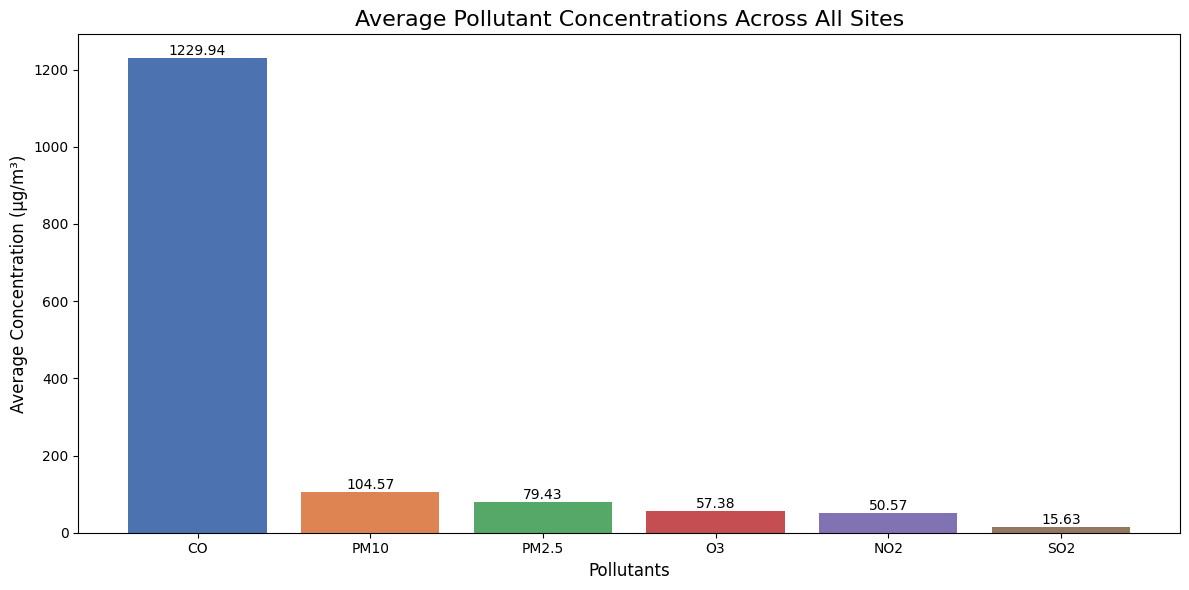

In [164]:
# Create a bar plot to visualize the average concentrations
plt.figure(figsize=(12, 6))  # Set the size of plot
bars = plt.bar(avg_concentrations.index, avg_concentrations.values, color=sns.color_palette("deep"))

# Add labels and title to plot
plt.title('Average Pollutant Concentrations Across All Sites', fontsize=16)
plt.xlabel('Pollutants', fontsize=12)
plt.ylabel('Average Concentration (μg/m³)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()  # Display the plot

In [165]:
# Identify the pollutant with the highest average concentration
highest_pollutant = avg_concentrations.index[0]
print(f"\nThe pollutant with the highest average concentration is: {highest_pollutant}")


The pollutant with the highest average concentration is: CO


3.2 Which weather conditions (e.g., wind speed, humidity) have the strongest influence on air quality?

Use a heatmap to visualize correlations between weather conditions and pollutants

In [166]:
# Define the pollutants and weather conditions we want to analyze
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
weather_conditions = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Calculate the correlation between weather conditions and pollutants
# This helps us understand how weather affects air quality
correlations = merged_data[weather_conditions + pollutants].corr().loc[weather_conditions, pollutants]

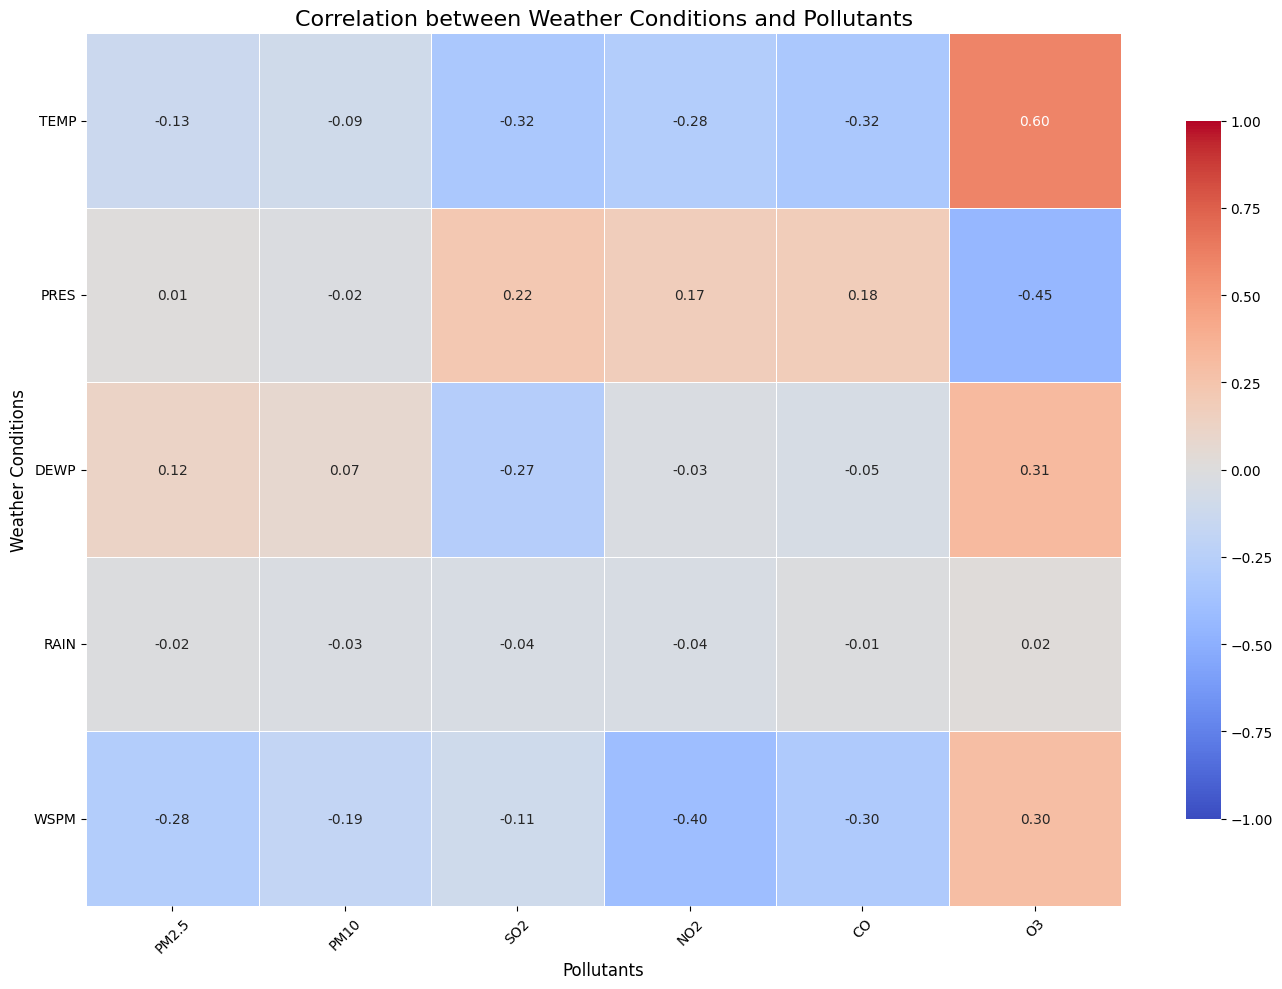

In [167]:
# Create a heatmap to visualize the correlations
plt.figure(figsize=(14, 10))  # Set the size of plot
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            linewidths=0.5, fmt='.2f', cbar_kws={"shrink": .8})

# Add labels and title to make plot more informative
plt.title('Correlation between Weather Conditions and Pollutants', fontsize=16)
plt.xlabel('Pollutants', fontsize=12)
plt.ylabel('Weather Conditions', fontsize=12)
plt.xticks(fontsize=10, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()  # Display the plot

In [168]:
# Find the weather condition with the strongest influence on each pollutant
strongest_influences = correlations.abs().idxmax()
print("\nWeather conditions with the strongest influence on each pollutant:")
for pollutant, condition in strongest_influences.items():
    correlation = correlations.loc[condition, pollutant]
    print(f"{pollutant}: {condition} (correlation: {correlation:.3f})")


Weather conditions with the strongest influence on each pollutant:
PM2.5: WSPM (correlation: -0.276)
PM10: WSPM (correlation: -0.186)
SO2: TEMP (correlation: -0.321)
NO2: WSPM (correlation: -0.403)
CO: TEMP (correlation: -0.323)
O3: TEMP (correlation: 0.597)


3.3 Is there a long-term trend in air quality improvement or deterioration over the years?

Create a grid of subplots to show long-term trends for each pollutant

In [169]:
# Convert 'No' to days (assuming 'No' represents hourly data)
merged_data['time'] = merged_data['No'] // 24  # 24 hours in a day

# Calculate daily averages for all pollutants
daily_averages = merged_data.groupby('time')[pollutants].mean()

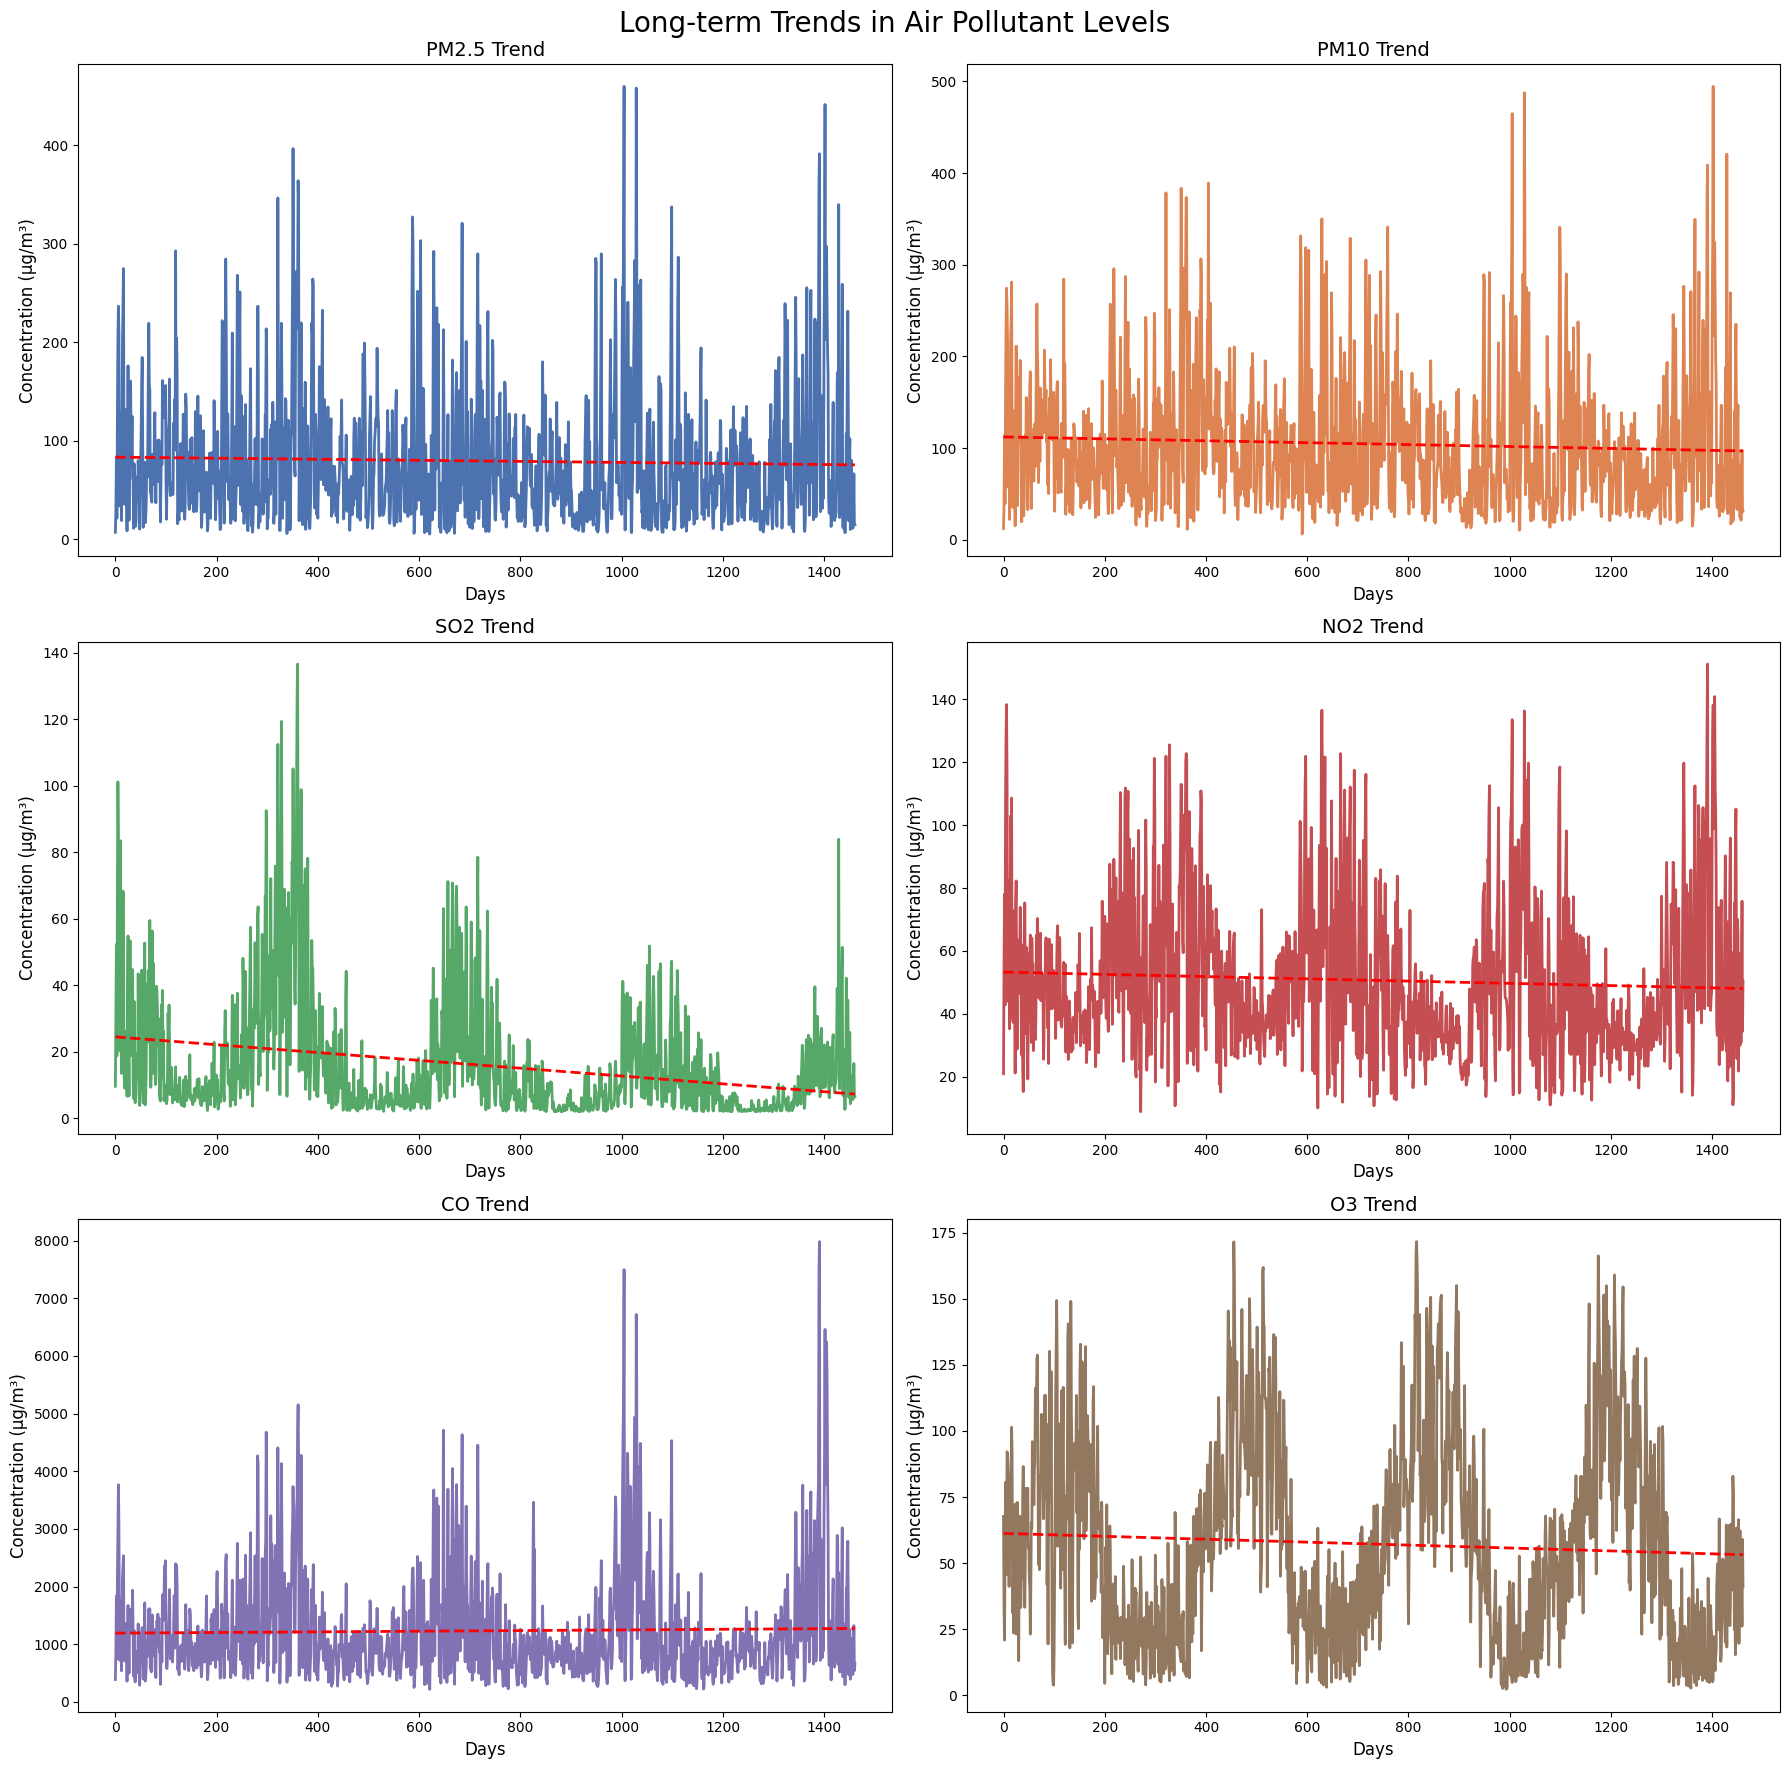

In [170]:
# Create a grid of subplots, one for each pollutant
fig, axes = plt.subplots(3, 2, figsize=(18, 18))  # 3 rows, 2 columns
fig.suptitle('Long-term Trends in Air Pollutant Levels', fontsize=20)

# Use different colors for each pollutant
colors = sns.color_palette("deep", 6)

# Loop through each pollutant and create a subplot
for i, pollutant in enumerate(pollutants):
    row = i // 2  # Determine which row the subplot should be in
    col = i % 2   # Determine which column the subplot should be in
    
    # Plot the pollutant data
    axes[row, col].plot(daily_averages.index, daily_averages[pollutant], color=colors[i], linewidth=2)
    axes[row, col].set_title(f'{pollutant} Trend', fontsize=14)
    axes[row, col].set_xlabel('Days', fontsize=12)
    axes[row, col].set_ylabel('Concentration (μg/m³)', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)
    
    # Add a trend line to show the overall direction
    z = np.polyfit(daily_averages.index, daily_averages[pollutant], 1)
    p = np.poly1d(z)
    axes[row, col].plot(daily_averages.index, p(daily_averages.index), "r--", linewidth=2)

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.subplots_adjust(top=0.95)  # Adjust the top margin to fit the main title
plt.show()  # Display the plot

In [171]:
# Calculate and print trend statistics for each pollutant
print("Long-term trends for each pollutant:")
for pollutant in pollutants:
    # Perform linear regression to determine the trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(daily_averages.index, daily_averages[pollutant])
    print(f"\n{pollutant}:")
    print(f"  Slope: {slope:.6f}")
    print(f"  P-value: {p_value:.6f}")
    
    # Interpret the results
    if p_value < 0.05:  # If the trend is statistically significant
        if slope < 0:
            print(f"  There is a statistically significant decrease in {pollutant} levels over time.")
            print(f"  This suggests an improvement in air quality for {pollutant}.")
        else:
            print(f"  There is a statistically significant increase in {pollutant} levels over time.")
            print(f"  This suggests a deterioration in air quality for {pollutant}.")
    else:
        print(f"  There is no statistically significant trend in {pollutant} levels over time.")

Long-term trends for each pollutant:

PM2.5:
  Slope: -0.005355
  P-value: 0.198543
  There is no statistically significant trend in PM2.5 levels over time.

PM10:
  Slope: -0.010453
  P-value: 0.018279
  There is a statistically significant decrease in PM10 levels over time.
  This suggests an improvement in air quality for PM10.

SO2:
  Slope: -0.011770
  P-value: 0.000000
  There is a statistically significant decrease in SO2 levels over time.
  This suggests an improvement in air quality for SO2.

NO2:
  Slope: -0.003574
  P-value: 0.017070
  There is a statistically significant decrease in NO2 levels over time.
  This suggests an improvement in air quality for NO2.

CO:
  Slope: 0.055371
  P-value: 0.337325
  There is no statistically significant trend in CO levels over time.

O3:
  Slope: -0.005523
  P-value: 0.016854
  There is a statistically significant decrease in O3 levels over time.
  This suggests an improvement in air quality for O3.


## **Conclusion**


*   Which pollutant has the highest average concentration across all monitoring sites?
  > According to the analysis, **Carbon Monoxide (CO)** has the highest average concentration of **1229.94 μg/m³** across all monitoring sites, far exceeding other pollutants. This is followed by **PM10** at **104.57 μg/m³** and **PM2.5** at **79.43 μg/m³**, suggesting that particulate matter and CO are key air quality concerns.

*   Which weather conditions (e.g., wind speed, humidity) have the strongest influence on air quality?
  > The data reveals that **wind speed (WSPM)** and **temperature (TEMP)** have the most significant correlations with pollutant levels. **Wind speed** shows moderate negative correlations with pollutants like **NO2 (-0.40)** and **CO (-0.30)**, indicating that stronger winds help clear pollutants from the air. On the other hand, **temperature** has a positive correlation with **O3 (0.60)**, meaning warmer weather increases ozone levels but decreases other pollutants.

*   Is there a long-term trend in air quality improvement or deterioration over the years?
  > The trend analysis shows mixed results for different pollutants. **PM2.5** and **PM10** exhibit slight decreasing trends, pointing to modest improvements in particulate matter over time. **SO2** shows a more substantial decrease, indicating better control of sulfur dioxide emissions. However, **NO2** and **CO** remain relatively stable, while **O3** displays a slight upward trend, which may require attention in the future.